# Set realsense camera `without ROS`

W:  1280
H:  720
FPS:  30
Depth Scale is: 0.0010 m


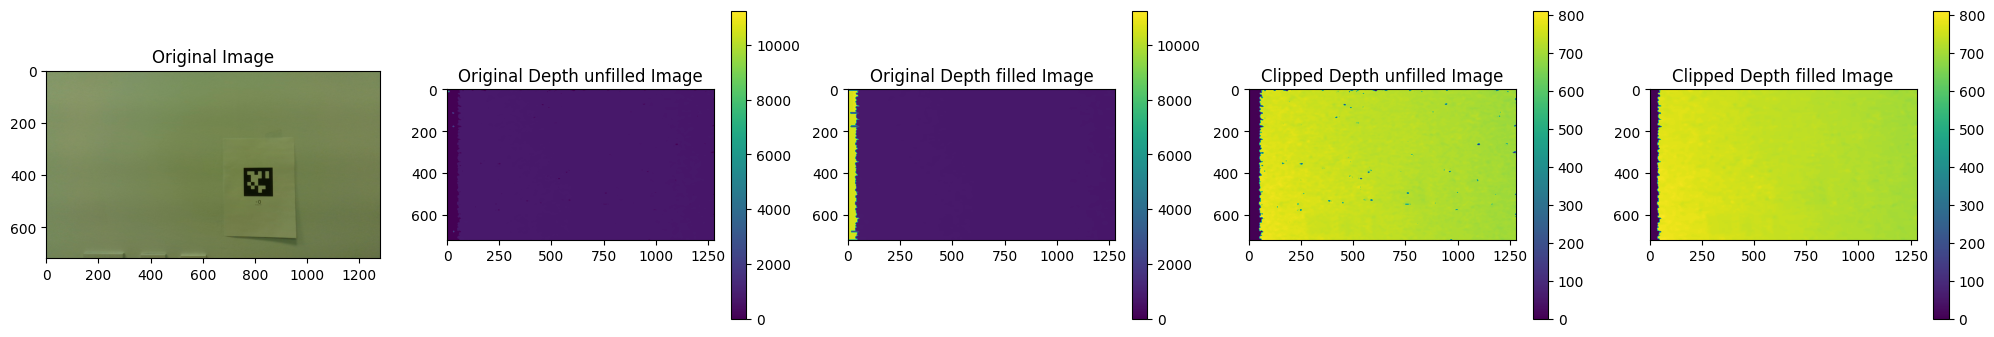

Frames Captured


In [1]:
import pyrealsense2 as rs
import numpy as np
import matplotlib.pyplot as plt
import cv2

import json

# Setup:
pipe = rs.pipeline()
config = rs.config()

# setting pre-defined camera parameters.
jsonObj = json.load(open("../cam_setting.json"))
json_string= str(jsonObj).replace("'", '\"')

print("W: ", int(jsonObj["viewer"]['stream-width']))
print("H: ", int(jsonObj["viewer"]['stream-height']))
print("FPS: ", int(jsonObj["viewer"]['stream-fps']))

config.enable_stream(rs.stream.depth, int(jsonObj["viewer"]['stream-width']), int(jsonObj["viewer"]['stream-height']), rs.format.z16, int(jsonObj["viewer"]['stream-fps']))
config.enable_stream(rs.stream.color, int(jsonObj["viewer"]['stream-width']), int(jsonObj["viewer"]['stream-height']), rs.format.bgr8, int(jsonObj["viewer"]['stream-fps']))
cfg = pipe.start(config)
# cfg = pipe.start() # Start pipeline and get the configuration it found

# profile = pipe.start(cfg)
profile = cfg.get_stream(rs.stream.depth) # Fetch stream profile for depth stream
intrinsic_matrix = profile.as_video_stream_profile().get_intrinsics() # Downcast to video_stream_profile and fetch intrinsics
# print(dir(cfg.get_device()))
depth_sensor = cfg.get_device().first_depth_sensor()        # depth sensor에 대한 것들을 얻자
depth_scale = depth_sensor.get_depth_scale()                # 깊이 센서의 깊이 스케일 얻음
print(f"Depth Scale is: {depth_scale:.4f} m")

for x in range(5):
  pipe.wait_for_frames()
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
rgb_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

# Apply filter to fill the Holes in the depth image
spatial = rs.spatial_filter()
spatial.set_option(rs.option.holes_fill, 3)
filtered_depth = spatial.process(depth_frame)

hole_filling = rs.hole_filling_filter()
filled_depth = hole_filling.process(filtered_depth)

depth_image_unfilled = np.asanyarray(depth_frame.get_data())
depth_image_filled = np.asanyarray(filled_depth.get_data())
color_image = np.asanyarray(rgb_frame.get_data())

grey_color = 0
clipping_distance_in_meters = 2    # 1 meter, 클리핑할 영역을 1m로 설정
clipping_distance = clipping_distance_in_meters / depth_scale   #스케일에 따른 클리핑 거리
depth_clipped_unfilled = np.where((depth_image_unfilled > clipping_distance) | (depth_image_unfilled <= 0), grey_color, depth_image_unfilled)
depth_clipped_filled = np.where((depth_image_filled > clipping_distance) | (depth_image_filled <= 0), grey_color, depth_image_filled)

plt.figure(figsize=(25,4))
plt.subplot(1,5,1)
plt.title("Original Image")
plt.imshow(color_image)
# plt.show()

plt.subplot(1,5,2)
plt.title("Original Depth unfilled Image")
plt.imshow(depth_image_unfilled)
plt.colorbar()
# plt.show()

plt.subplot(1,5,3)
plt.title("Original Depth filled Image")
plt.imshow(depth_image_filled)
plt.colorbar()
# plt.show()

plt.subplot(1,5,4)
plt.title("Clipped Depth unfilled Image")
plt.imshow(depth_clipped_unfilled)
plt.colorbar()
# plt.show()

plt.subplot(1,5,5)
plt.title("Clipped Depth filled Image")
plt.imshow(depth_clipped_filled)
plt.colorbar()
plt.show()

# Cleanup:
pipe.stop()
print("Frames Captured")

# Compute 2D img to `3D` img

In [2]:
def convert_from_uvd(u, v, d, cam_matrix):
    """
        pxToMetre: Constant, depth scale factor
        cx: Center x of Camera
        cy: Center y of Camera
        focalx: Focal length
        focaly: Focal length 
    """

    pxToMetre = 1

    focalx = cam_matrix[0][0]
    cx = cam_matrix[0][2]
    focaly = cam_matrix[1][1]
    cy = cam_matrix[1][2]

    d *= pxToMetre
    x_over_z = (cx - u) / focalx
    y_over_z = (cy - v) / focaly
    z = d / np.sqrt(1. + x_over_z**2 + y_over_z**2)
    x = x_over_z * z
    y = y_over_z * z

    return -y, x, z

def compute_xyz(depth_img, camera_info):

    # , fx, fy, px, py, height, width
    fx = camera_info.fx
    cx = camera_info.ppx
    fy = camera_info.fx
    cy = camera_info.ppy

    height = camera_info.height
    width = camera_info.width

    indices = np.indices((height, width), dtype=np.float32).transpose(1, 2, 0)
    
    z_e = depth_img
    x_e = (indices[..., 1] - cx) * z_e / fx
    y_e = (indices[..., 0] - cy) * z_e / fy
    
    # Order of y_ e is reversed !
    xyz_img = np.stack([-y_e, x_e, z_e], axis=-1) # Shape: [H x W x 3]
    return xyz_img

In [3]:
img_xyz_unfilled = compute_xyz(depth_image_unfilled, camera_info=intrinsic_matrix)
img_xyz_filled = compute_xyz(depth_image_filled, camera_info=intrinsic_matrix)
img_xyz_clipped_unfilled = compute_xyz(depth_clipped_unfilled, camera_info=intrinsic_matrix)
img_xyz_clipped_filled = compute_xyz(depth_clipped_filled, camera_info=intrinsic_matrix)

print(img_xyz_unfilled.shape)
print(img_xyz_filled.shape)
print(img_xyz_clipped_unfilled.shape)
print(img_xyz_clipped_filled.shape)

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


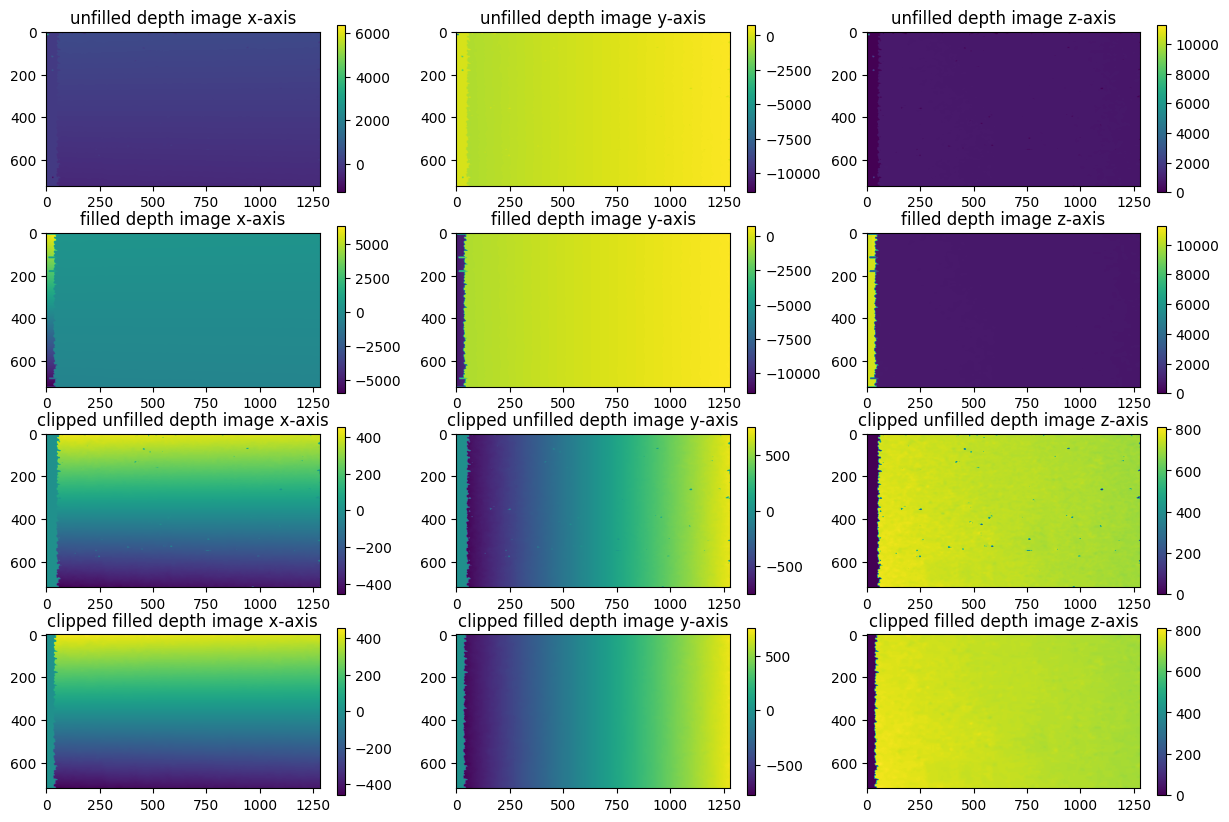

In [4]:
plt.figure(figsize=(15,10))
axis = ['x', 'y', 'z']

for i in range(3):
    plt.subplot(4,3,i+1)
    plt.title(f"unfilled depth image {axis[i]}-axis")
    plt.imshow(img_xyz_unfilled[:,:,i])
    plt.colorbar()
    # plt.show()
    plt.subplot(4,3,i+4)
    plt.title(f"filled depth image {axis[i]}-axis")
    plt.imshow(img_xyz_filled[:,:,i])
    plt.colorbar()

    plt.subplot(4,3,i+7)
    plt.title(f"clipped unfilled depth image {axis[i]}-axis")
    plt.imshow(img_xyz_clipped_unfilled[:,:,i])
    plt.colorbar()

    plt.subplot(4,3,i+10)
    plt.title(f"clipped filled depth image {axis[i]}-axis")
    plt.imshow(img_xyz_clipped_filled[:,:,i])
    plt.colorbar()

plt.show()

# Detect `AprilTag`

In [5]:
def draw_bbox(results, image, intrinsic_matrix, verbose=False, plot_img=True):
    width = intrinsic_matrix.width
    height = intrinsic_matrix.height

    for r in results:
        # extract the bounding box (x, y)-coordinates for the AprilTag
        # and convert each of the (x, y)-coordinate pairs to integers
        (ptA, ptB, ptC, ptD) = r.corners
        ptB = (int(ptB[0]), int(ptB[1]))
        ptC = (int(ptC[0]), int(ptC[1]))
        ptD = (int(ptD[0]), int(ptD[1]))
        ptA = (int(ptA[0]), int(ptA[1]))

        # draw the bounding box of the AprilTag detection
        cv2.line(image, ptA, ptB, (255, 0, 0), 3)
        cv2.line(image, ptB, ptC, (255, 0, 0), 3)
        cv2.line(image, ptC, ptD, (255, 0, 0), 3)
        cv2.line(image, ptD, ptA, (255, 0, 0), 3)

        # draw the center (x, y)-coordinates of the AprilTag
        (cX, cY) = (int(r.center[0]), int(r.center[1]))
        cv2.circle(image, (cX, cY), 5, (0, 0, 255), -1)

        # draw the tag family on the image
        tagFamily = r.tag_family.decode("utf-8")
    
        if verbose:
            cv2.putText(image, tagFamily, (ptA[0], ptA[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 5.0, (255, 255, 255), 3)
            # print("Apriltag name: {}".format(tagFamily))

            x_centered = cX - width / 2
            y_centered = -1 * (cY - height / 2)

            cv2.putText(image, f"Center X coord: {x_centered}", (ptB[0] + 10, ptB[1] - 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.5, (125, 0, 125), 7)

            cv2.putText(image, f"Center Y coord: {y_centered}", (ptB[0] + 10, ptB[1]),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, (125, 0, 125), 7)

            cv2.putText(image, f"Tag ID: {r.tag_id}", (ptC[0] - 70, ptC[1] - 15),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (125, 0, 125), 7)

        # cv2.circle(image, (int((width / 2)), int((height / 2))), 5, (0, 0, 255), 2)

    if plot_img:
        plt.imshow(image)
        plt.show()


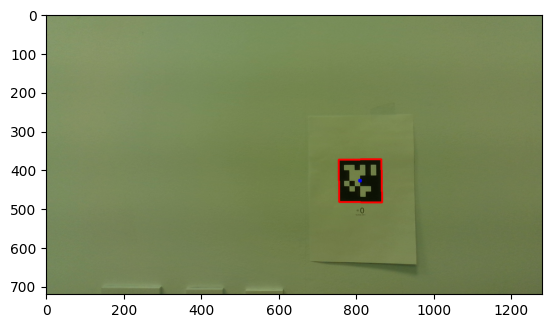

[Detection(tag_family=b'tag36h11', tag_id=0, hamming=0, goodness=0.0, decision_margin=49.18980407714844, homography=array([[ 6.37970944e-01, -1.43426062e-02,  1.03974914e+01],
        [-4.12970345e-02,  6.90786375e-01,  5.50135899e+00],
        [-8.99617864e-05, -2.85872884e-05,  1.28245636e-02]]), center=array([810.74816623, 428.97046272]), corners=array([[755.14007568, 374.8611145 ],
        [865.75579834, 373.67428589],
        [867.3939209 , 484.08950806],
        [756.26452637, 483.73989868]]))]

In [6]:
import apriltag
import cv2

detector = apriltag.Detector()

img_BGR = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)
img_Gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)

results = detector.detect(img_Gray)
draw_bbox(results, color_image, intrinsic_matrix=intrinsic_matrix, verbose=False, plot_img=True)

results

In [7]:
cam_params = [intrinsic_matrix.fx, intrinsic_matrix.fy, intrinsic_matrix.ppx, intrinsic_matrix.ppy]
cam_params

[627.9202880859375, 627.9202880859375, 640.234130859375, 363.47833251953125]

In [8]:
pose, e0, e1 = detector.detection_pose(detection=results[0], camera_params=cam_params, tag_size=0.06)    # should check tag_size

poseRotation = pose[:3, :3]
poseTranslation = pose[:3, 3]

center_point = [int(results[0].center[i]) for i in range(2)]    # in int type

rot_april = pose[:3, :3]
center_3d = np.array([img_xyz_filled[center_point[1]][center_point[0]]])   # order of pixel array is y, x 

T_april = np.concatenate((rot_april, center_3d.T), axis=1)  # 4x3 matrix
T_april = np.concatenate((T_april, np.array([[0,0,0,1]])), axis=0)  # 4x4 matrix


In [9]:
print(rot_april)
print(center_3d)

[[ 0.99827375  0.00834422  0.05813678]
 [-0.00935641  0.99980898  0.01716008]
 [-0.05798249 -0.01767441  0.99816113]]
[[-73.88052 194.39037 719.     ]]


In [10]:
# draw_bbox(results, color_image, intrinsic_matrix=intrinsic_matrix, verbose=False, plot_img=True)

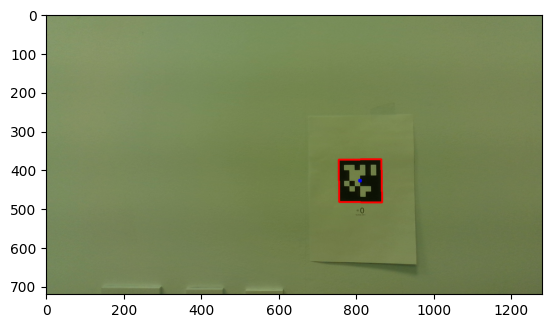

In [11]:
draw_bbox(results, color_image, intrinsic_matrix=intrinsic_matrix, verbose=False, plot_img=True)

# pose estimation about `AprilTag`

[Detection(tag_family=b'tag36h11', tag_id=0, hamming=0, goodness=0.0, decision_margin=48.94166564941406, homography=array([[ 5.28862311e-01, -7.42371903e-03,  1.08900021e+01],
       [-9.51711548e-02,  6.94308061e-01,  5.76377074e+00],
       [-2.21672519e-04, -2.53159854e-05,  1.34382774e-02]]), center=array([810.37188015, 428.90696263]), corners=array([[757.64428711, 377.38644409],
       [862.88751221, 375.64727783],
       [865.07397461, 482.35678101],
       [759.36883545, 480.63262939]]))]


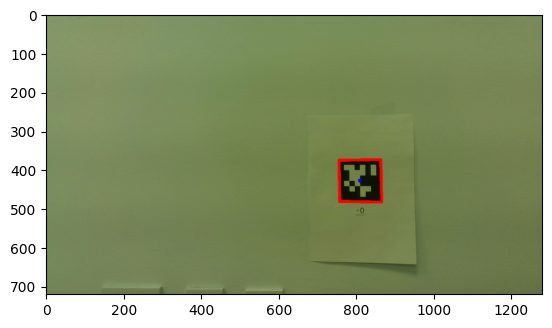

array([[ 9.97097376e-01,  3.80727442e-03,  7.60416157e-02,
        -7.34695053e+01],
       [-7.96348720e-03,  9.98485892e-01,  5.44289117e-02,
         1.93308914e+02],
       [-7.57192547e-02, -5.48764815e-02,  9.95617982e-01,
         7.15000000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [13]:
import apriltag

def get_apriltag_pose(img, img_depth, intrinsic_matrix, tag_size=0.008):
    """
        In AX=XB Equation, (extrinsic calibration) 
        Get matrix about A that represents detected AprilTag pose in camera coordinate.
    """
    # camera parameter setting.
    fx = intrinsic_matrix.fx
    fy = intrinsic_matrix.fy
    ppx = intrinsic_matrix.ppx
    ppy = intrinsic_matrix.ppy

    cam_params = [fx, fy, ppx, ppy]

    # apriltag setting.
    detector = apriltag.Detector()

    img_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img_Gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)
    img_xyz = compute_xyz(img_depth, camera_info=intrinsic_matrix)   # 3d estimated img

    results = detector.detect(img_Gray)

    print(results)

    # Check the detections on the image
    if len(results) > 0:
        draw_bbox(results, img, intrinsic_matrix=intrinsic_matrix, verbose=False, plot_img=True)

        for r in results:
            pose, e0, e1 = detector.detection_pose(detection=r, camera_params=cam_params, tag_size=tag_size)    # should check tag_size
            
            poseRotation = pose[:3, :3]
            poseTranslation = pose[:3, 3]
    
            center_point = [int(r.center[i]) for i in range(2)]    # in int type

            rot_april = pose[:3, :3]
            center_3d = np.array([img_xyz[center_point[1]][center_point[0]]])   # order of pixel array is y, x 

            T_april = np.concatenate((rot_april, center_3d.T), axis=1)  # 4x3 matrix
            T_april = np.concatenate((T_april, np.array([[0,0,0,1]])), axis=0)  # 4x4 matrix

        return T_april

    else:   # if any detected marker is none, return None.
        print("There's no april tag")
        return None

# depth_image_unfilled
# depth_image_filled
# depth_clipped_unfilled
# depth_clipped_filled
get_apriltag_pose(color_image, depth_image_unfilled, intrinsic_matrix=intrinsic_matrix, tag_size=0.008)

In [14]:
Pose = np.array(([[ 9.97097376e-01,  3.80727442e-03,  7.60416157e-02,
        -7.34695053e+01],
       [-7.96348720e-03,  9.98485892e-01,  5.44289117e-02,
         1.93308914e+02],
       [-7.57192547e-02, -5.48764815e-02,  9.95617982e-01,
         7.15000000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]))

In [16]:
Pose[:3,:3]

array([[ 0.99709738,  0.00380727,  0.07604162],
       [-0.00796349,  0.99848589,  0.05442891],
       [-0.07571925, -0.05487648,  0.99561798]])

In [18]:
Pose[:3,3]

array([-73.4695053, 193.308914 , 715.       ])

# Get `Extrinsic` matrix

### get transformation matrix about `camera to robot E.E.` offset

In [ ]:
# extrinsic calibration using cv2.calibrateHandEye()
def get_extrinsic_calibration(env, img, img_depth, from_link="ur_rg2_gripper_base_link", to_link="ur_base_link"):
    # Get matrix A.
    # Transformation matrix about 'camera to target'.
    tagpose = get_apriltag_pose(env, img, img_depth)
    R_cam2target = tagpose[:3, :3]
    p_cam2target = tagpose[:3, 3]
    p_target2cam = -np.linalg.inv(R_cam2target) @ p_cam2target
    R_target2cam = np.linalg.inv(R_cam2target)

    # Get matrix B.
    # Transformation matrix about 'ee to base'.
    T_ee2bs = get_homogeneous_matrix(env, from_link=from_link, to_link=to_link, verbose=False)
    R_ee2bs = T_ee2bs[:3, :3]
    p_ee2bs = T_ee2bs[:3, 3]

    R_ext, p_ext = cv2.calibrateHandEye(R_ee2bs, p_ee2bs, R_target2cam, p_target2cam, method=cv2.CALIB_HAND_EYE_TSAI)

    T_extrinsic = cv2.hconcat((R_ext, p_ext))      # 3x4
    T_extrinsic = np.vstack((T_extrinsic, np.array([0,0,0,1])))   # 4x4

    return T_extrinsic

##### Get extrinsic matrix btw `rgb` and `depth` camera

Loading Intel Realsense Camera
Depth Scale is:  0.0010000000474974513


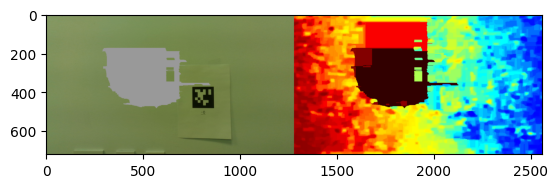

Frames Captured


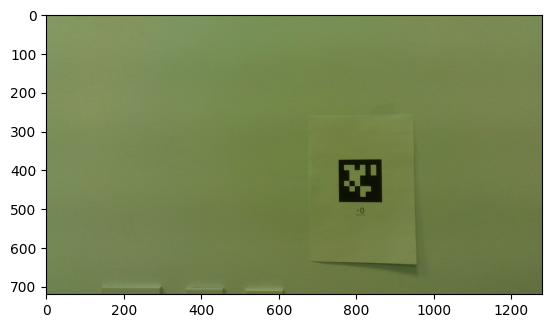

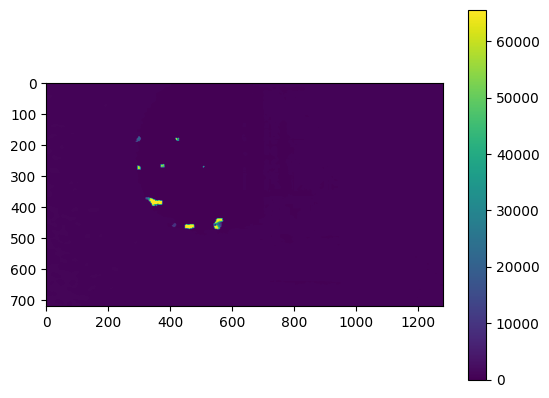

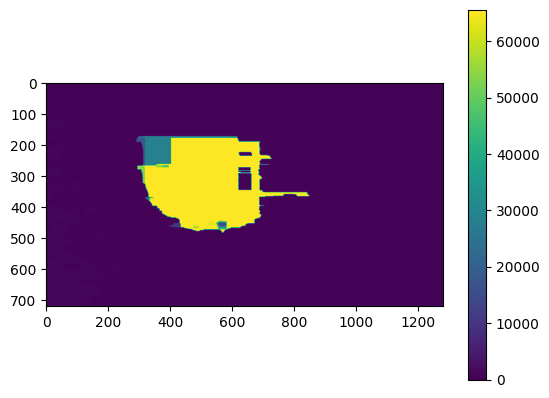

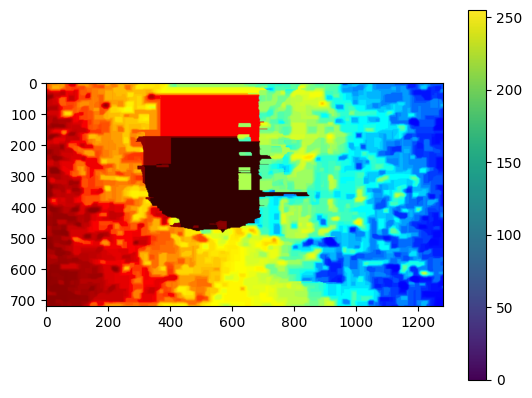

In [41]:
print("Loading Intel Realsense Camera")
pipeline = rs.pipeline()

config = rs.config()
config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)
config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)

# Start streaming
# pipeline.start(config)

profile = pipeline.start(config)   # pipeline start

depth_sensor = profile.get_device().first_depth_sensor()    # depth sensor에 대한 것들을 얻자
depth_scale = depth_sensor.get_depth_scale()                # 깊이 센서의 깊이 스케일 얻음
print("Depth Scale is: ", depth_scale)

clipping_distance_in_meters = 10    # 1 meter, set clipping area: 1 meter.
clipping_distance = clipping_distance_in_meters / depth_scale   # clipping scale

align_to = rs.stream.color
align = rs.align(align_to)

frames = pipeline.wait_for_frames()
aligned_frames = align.process(frames)
depth_frame = aligned_frames.get_depth_frame()
color_frame = aligned_frames.get_color_frame()

if not depth_frame or not color_frame:
    # If there is no frame, probably camera not connected, return False
    print("Error, impossible to get the frame, make sure that the Intel Realsense camera is correctly connected")

# Apply filter to fill the Holes in the depth image
spatial = rs.spatial_filter()
spatial.set_option(rs.option.holes_fill, 3)
filtered_depth = spatial.process(depth_frame)

hole_filling = rs.hole_filling_filter()
filled_depth = hole_filling.process(filtered_depth)


# Create colormap to show the depth of the Objects
colorizer = rs.colorizer()
depth_colormap = np.asanyarray(colorizer.colorize(filled_depth).get_data())

# Convert images to numpy arrays
# distance = depth_frame.get_distance(int(50),int(50))
# print("distance", distance)
depth_image_unfilled = np.asanyarray(depth_frame.get_data())
depth_image = np.asanyarray(filled_depth.get_data())
color_image = np.asanyarray(color_frame.get_data())

#백그라운드 제거
grey_color = 153
depth_image_3d = np.dstack((depth_image, depth_image, depth_image))  #depth image는 1채널, 컬러 이미지는 3채널
bg_removed = np.where((depth_image_3d > clipping_distance) | (depth_image_3d <= 0), grey_color, color_image)
# 클리핑 거리를 깊이 _이미지가 넘어서거나, 0보다 적으면, 회색으로 아니면 컬러 이미지로 반환

images = np.hstack((bg_removed, depth_colormap))  #두 이미지를 수평으로 연결
plt.imshow(images)
plt.show()


# Cleanup:
pipeline.stop()
print("Frames Captured")

plt.imshow(color_image)
plt.show()

plt.imshow(depth_image_unfilled)
plt.colorbar()
plt.show()

plt.imshow(depth_image)
plt.colorbar()
plt.show()

plt.imshow(depth_colormap)
plt.colorbar()
plt.show()



In [62]:
depth_scale = depth_sensor.get_depth_scale()                # 깊이 센서의 깊이 스케일 얻음
print("Depth Scale is: ", depth_scale)

clipping_distance_in_meters = 3    # 1 meter, 클리핑할 영역을 1m로 설정
clipping_distance = clipping_distance_in_meters / depth_scale   #스케일에 따른 클리핑 거리
#백그라운드 제거
grey_color = 153
depth_image_3d = np.dstack((depth_image, depth_image, depth_image))  #depth image는 1채널, 컬러 이미지는 3채널
bg_removed = np.where((depth_image_3d > clipping_distance) | (depth_image_3d <= 0), grey_color, color_image)
# 클리핑 거리를 깊이 _이미지가 넘어서거나, 0보다 적으면, 회색으로 아니면 컬러 이미지로 반환

#이미지 렌더링
depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
    # applyColorMap(src, 필터) 필터를 적용함 , COLORMAP_JET=  연속적인 색상, blue -> red
    # convertScaleAbs: 인자적용 후 절대값, 8비트 반환


Depth Scale is:  0.0010000000474974513


In [137]:
import pyrealsense2 as rs

pipeline = rs.pipeline()
pipe_profile = pipeline.start()
frames = pipeline.wait_for_frames()
depth_frame = frames.get_depth_frame()
color_frame = frames.get_color_frame()

# Intrinsics & Extrinsics
depth_intrin = depth_frame.profile.as_video_stream_profile().intrinsics
color_intrin = color_frame.profile.as_video_stream_profile().intrinsics
depth_to_color_extrin = depth_frame.profile.get_extrinsics_to(color_frame.profile)

# Depth scale - units of the values inside a depth frame, i.e how to convert the value to units of 1 meter
depth_sensor = pipe_profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
print(depth_scale)

clipping_distance_in_meters = 3    # 1 meter, 클리핑할 영역을 1m로 설정
clipping_distance = clipping_distance_in_meters / depth_scale   #스케일에 따른 클리핑 거리
print(clipping_distance)

# Map depth to color
depth_pixel = [240, 320]   # Random pixel
depth_point = rs.rs2_deproject_pixel_to_point(depth_intrin, depth_pixel, depth_scale)
color_point = rs.rs2_transform_point_to_point(depth_to_color_extrin, depth_point)
color_pixel = rs.rs2_project_point_to_pixel(color_intrin, color_point)
pipeline.stop()

0.0010000000474974513
2999.999857507653


In [138]:
depth_to_color_extrin

rotation: [0.999981, -0.00616398, -0.00054759, 0.00616487, 0.99998, 0.00164299, 0.000537451, -0.00164634, 0.999999]
translation: [0.0150884, -1.6874e-05, -9.37735e-05]

In [139]:
rot = np.array([0.999981, -0.00616398, -0.00054759, 0.00616487, 0.99998, 0.00164299, 0.000537451, -0.00164634, 0.999999])
trans = np.array([0.0150884, -1.6874e-05, -9.37735e-05])
rot = rot.reshape((3,3))

print(rot)
print(trans)

[[ 9.99981e-01 -6.16398e-03 -5.47590e-04]
 [ 6.16487e-03  9.99980e-01  1.64299e-03]
 [ 5.37451e-04 -1.64634e-03  9.99999e-01]]
[ 1.50884e-02 -1.68740e-05 -9.37735e-05]


In [140]:
depth_intrin

[ 848x480  p[424.155 242.304]  f[415.997 415.997]  Brown Conrady [0 0 0 0 0] ]

In [141]:
color_intrin

[ 640x480  p[318.983 250.64]  f[605.609 605.034]  Inverse Brown Conrady [0 0 0 0 0] ]

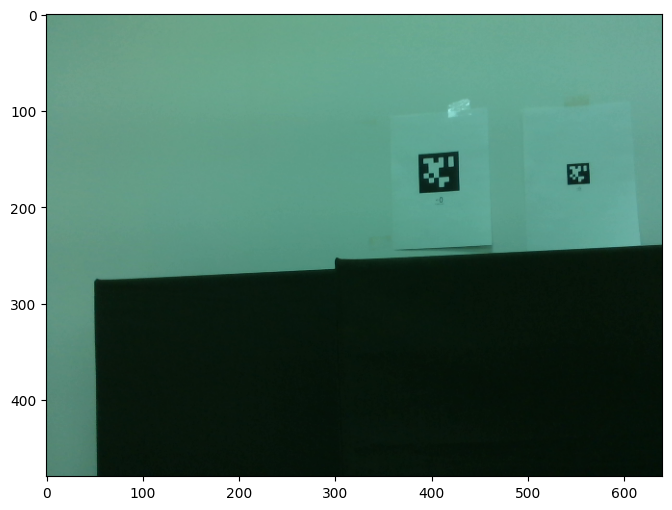

In [142]:
img_rgb = np.asanyarray(color_frame.get_data())

plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 6]
plt.imshow(img_rgb)
plt.show()

## Get `depth` image

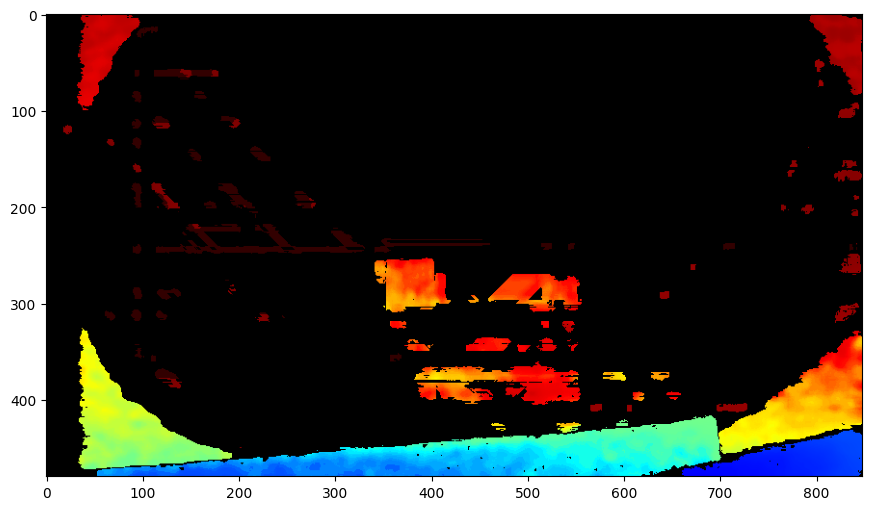

In [133]:
colorizer = rs.colorizer()
img_depth_colorized = np.asanyarray(colorizer.colorize(depth_frame).get_data())
plt.imshow(img_depth_colorized)
plt.show()

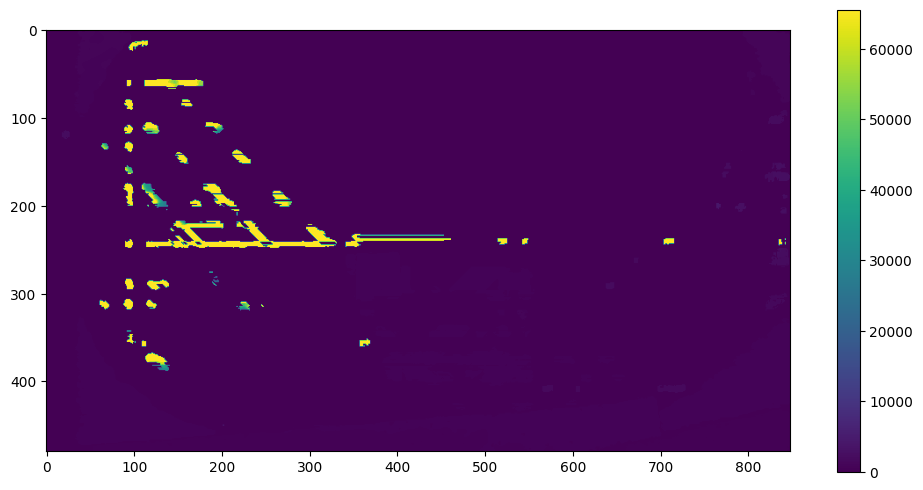

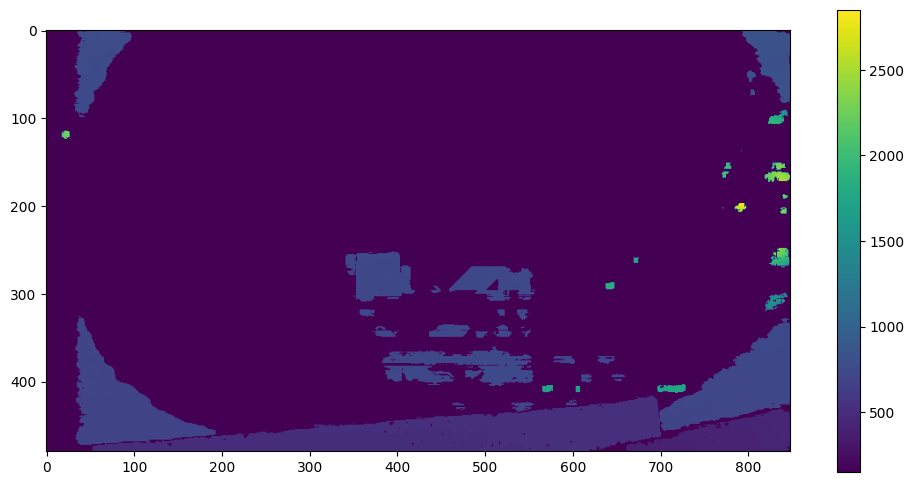

In [134]:
img_depth = np.asanyarray(depth_frame.get_data())

clip_dist = 3000   # 3 meter clipping.
img_depth_3d = np.dstack((img_depth, img_depth, img_depth))  #depth image는 1채널, 컬러 이미지는 3채널
bg_removed = np.where((img_depth > clip_dist) | (img_depth <= 0), 153, img_depth)
# bg_removed = np.where((img_depth > clip_dist) | (img_depth <= 0), 0, 0)

plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 6]
plt.imshow(img_depth)
plt.colorbar()
plt.show()

plt.imshow(bg_removed)
plt.colorbar()
plt.show()


# Alignment `RGB, Depth` image

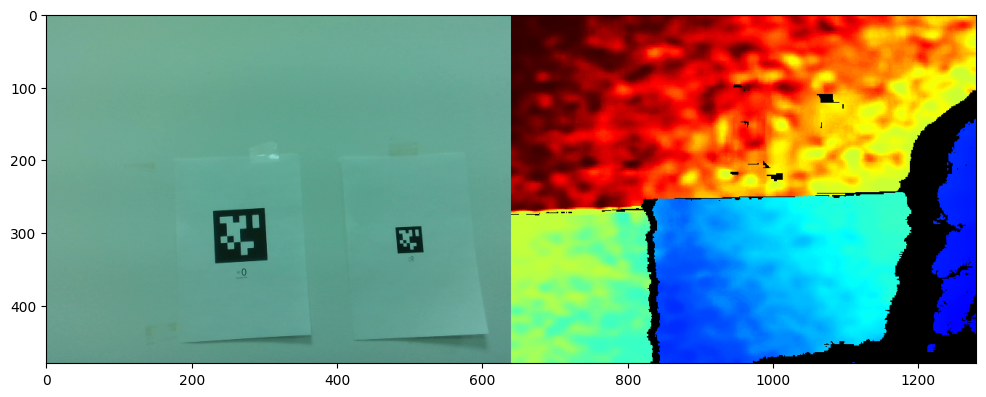

In [135]:
# Create alignment primitive with color as its target stream:
align = rs.align(rs.stream.color)
frameset = align.process(frameset)

# Update color and depth frames:
aligned_depth_frame = frameset.get_depth_frame()
colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())

# Show the two frames together:
image_aligned = np.hstack((img_rgb, colorized_depth))
plt.imshow(image_aligned)
plt.show()

# pose estimation about `AprilTag`

In [ ]:
def draw_bbox(results, image, verbose=False):
    width = 1500
    height = 1000

    for r in results:
        # extract the bounding box (x, y)-coordinates for the AprilTag
        # and convert each of the (x, y)-coordinate pairs to integers
        (ptA, ptB, ptC, ptD) = r.corners
        ptB = (int(ptB[0]), int(ptB[1]))
        ptC = (int(ptC[0]), int(ptC[1]))
        ptD = (int(ptD[0]), int(ptD[1]))
        ptA = (int(ptA[0]), int(ptA[1]))

        # draw the bounding box of the AprilTag detection
        cv2.line(image, ptA, ptB, (255, 0, 0), 3)
        cv2.line(image, ptB, ptC, (255, 0, 0), 3)
        cv2.line(image, ptC, ptD, (255, 0, 0), 3)
        cv2.line(image, ptD, ptA, (255, 0, 0), 3)

        # draw the center (x, y)-coordinates of the AprilTag
        (cX, cY) = (int(r.center[0]), int(r.center[1]))
        cv2.circle(image, (cX, cY), 5, (0, 0, 255), -1)

        # draw the tag family on the image
        tagFamily = r.tag_family.decode("utf-8")
    
        if verbose == True:
            cv2.putText(image, tagFamily, (ptA[0], ptA[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 5.0, (255, 255, 255), 3)
            # print("Apriltag name: {}".format(tagFamily))

            x_centered = cX - width / 2
            y_centered = -1 * (cY - height / 2)

            cv2.putText(image, f"Center X coord: {x_centered}", (ptB[0] + 10, ptB[1] - 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.5, (125, 0, 125), 7)

            cv2.putText(image, f"Center Y coord: {y_centered}", (ptB[0] + 10, ptB[1]),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, (125, 0, 125), 7)

            cv2.putText(image, f"Tag ID: {r.tag_id}", (ptC[0] - 70, ptC[1] - 15),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (125, 0, 125), 7)

        cv2.circle(image, (int((width / 2)), int((height / 2))), 5, (0, 0, 255), 2)

    plt.imshow(image)
    plt.show()

In [ ]:
import apriltag
import cv2

detector = apriltag.Detector()

img_BGR = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
img_Gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)

results = detector.detect(img_Gray)


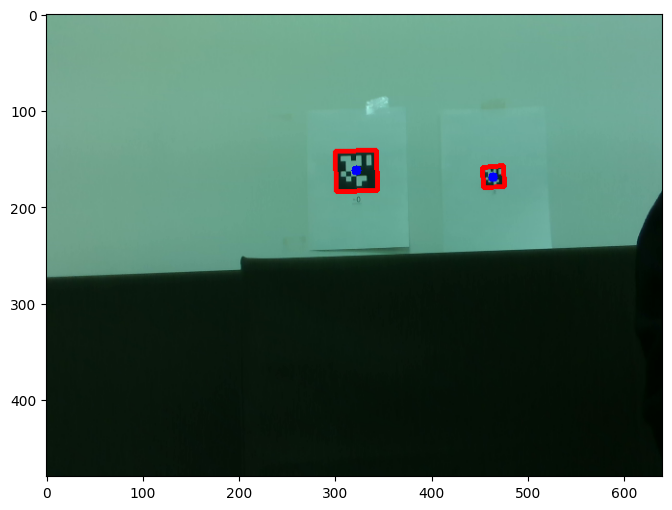

In [ ]:
draw_bbox(results, img_rgb, verbose=False)

In [ ]:
def convert_from_uvd(u, v, d, cam_matrix):
    """
        pxToMetre: Constant, depth scale factor
        cx: Center x of Camera
        cy: Center y of Camera
        focalx: Focal length
        focaly: Focal length 
    """

    pxToMetre = 1

    focalx = cam_matrix[0][0]
    cx = cam_matrix[0][2]
    focaly = cam_matrix[1][1]
    cy = cam_matrix[1][2]

    d *= pxToMetre
    x_over_z = (cx - u) / focalx
    y_over_z = (cy - v) / focaly
    z = d / np.sqrt(1. + x_over_z**2 + y_over_z**2)
    x = x_over_z * z
    y = y_over_z * z

    return -y, x, z

def compute_xyz(depth_img, camera_info):

    # , fx, fy, px, py, height, width
    fx = camera_info.fx
    cx = camera_info.ppx
    fy = camera_info.fx
    cy = camera_info.ppy

    height = camera_info.height
    width = camera_info.width

    indices = np.indices((height, width), dtype=np.float32).transpose(1, 2, 0)
    
    z_e = depth_img
    x_e = (indices[..., 1] - cx) * z_e / fx
    y_e = (indices[..., 0] - cy) * z_e / fy
    
    # Order of y_ e is reversed !
    xyz_img = np.stack([-y_e, x_e, z_e], axis=-1) # Shape: [H x W x 3]
    return xyz_img

In [ ]:
img_depth.shape

(480, 848)

In [ ]:
cam_matrix = np.zeros((3, 3))
cam_matrix[0][0] = intrinsic_matrix.fx
cam_matrix[0][2] = intrinsic_matrix.ppx
cam_matrix[1][1] = intrinsic_matrix.fy
cam_matrix[1][2] = intrinsic_matrix.ppy


In [ ]:
intrinsic_matrix.

[ 848x480  p[424.155 242.304]  f[415.997 415.997]  Brown Conrady [0 0 0 0 0] ]

In [ ]:
img_xyz = compute_xyz(img_depth, camera_info=intrinsic_matrix)


In [ ]:
img_xyz.shape

(480, 848, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


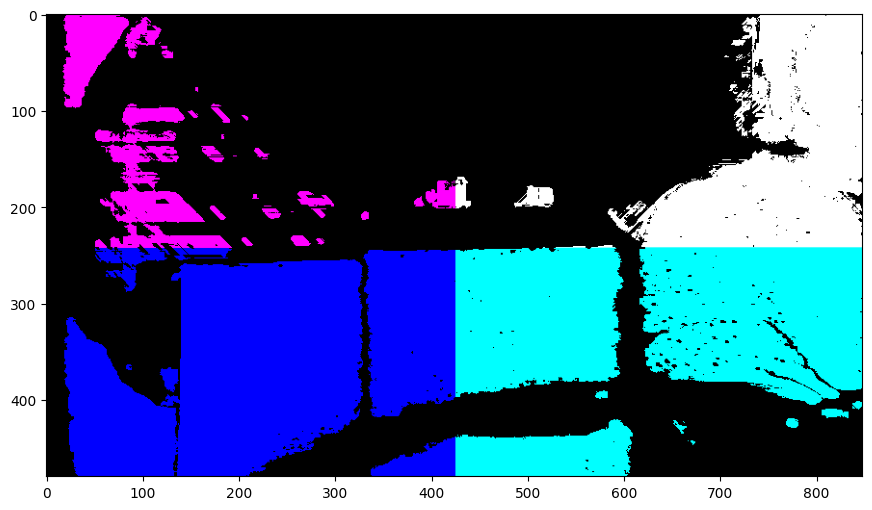

In [ ]:
plt.imshow(img_xyz)
plt.show()

In [ ]:
fx, fy, cx, cy = [ ctypes.c_double(c) for c in camera_params ]
fx = camera_info.fx
cx = camera_info.ppx
fy = camera_info.fx
cy = camera_info.ppy


In [ ]:
cam_params = [camera_info.fx, camera_info.fy, camera_info.ppx, camera_info.ppy]

In [ ]:
pose, e0, e1 = detector.detection_pose(detection=results[0], camera_params=cam_params, tag_size=0.06)    # should check tag_size

poseRotation = pose[:3, :3]
poseTranslation = pose[:3, 3]

center_point = [int(results[0].center[i]) for i in range(2)]    # in int type

rot_april = pose[:3, :3]
center_3d = np.array([img_xyz[center_point[1]][center_point[0]]])   # order of pixel array is y, x 

T_april = np.concatenate((rot_april, center_3d.T), axis=1)  # 4x3 matrix
T_april = np.concatenate((T_april, np.array([[0,0,0,1]])), axis=0)  # 4x4 matrix


In [10]:
(ptA, ptB, ptC, ptD) = results[0].corners
ptB = (int(ptB[0]), int(ptB[1]))
ptC = (int(ptC[0]), int(ptC[1]))
ptD = (int(ptD[0]), int(ptD[1]))
ptA = (int(ptA[0]), int(ptA[1]))


In [11]:
results[1].corners

array([[451.81600952, 156.46554565],
       [474.93734741, 155.87054443],
       [475.10064697, 177.77792358],
       [453.19735718, 178.24406433]])

In [12]:
results[0].corners

array([[298.9616394 , 140.67233276],
       [341.81494141, 139.13792419],
       [342.07846069, 181.54258728],
       [299.16876221, 182.7852478 ]])

In [14]:
cfg = pipe.start() # Start pipeline and get the configuration it found
profile = cfg.get_stream(rs.stream.depth) # Fetch stream profile for depth stream


In [16]:
camera_intrinsic = profile.as_video_stream_profile().get_intrinsics() # Downcast to video_stream_profile and fetch intrinsics

camera_intrinsic

[ 848x480  p[424.155 242.304]  f[415.997 415.997]  Brown Conrady [0 0 0 0 0] ]

In [67]:
rs.intrinsics()

[ 0x0  p[0 0]  f[0 0]  None [0 0 0 0 0] ]

In [81]:
depth_intrinsic = aligned_depth_frame.profile.as_video_stream_profile().intrinsics
print(depth_intrinsic.width)
print(depth_intrinsic.height)
print(depth_intrinsic.ppx)
print(depth_intrinsic.ppy)
print(depth_intrinsic.fx)
print(depth_intrinsic.fy)
print(depth_intrinsic.model)
print(depth_intrinsic.coeffs)

cam_infos = {"width":depth_intrinsic.width, "height":depth_intrinsic.height, 
            "ppx":depth_intrinsic.ppx, "ppy":depth_intrinsic.ppy,
            "fx":depth_intrinsic.fx, "fy":depth_intrinsic.fy,
            "model":depth_intrinsic.model, "coeffs":depth_intrinsic.coeffs}
print(cam_infos)
print(depth_intrinsic)

640
480
318.9832763671875
250.6395721435547
605.6090087890625
605.0342407226562
distortion.inverse_brown_conrady
[0.0, 0.0, 0.0, 0.0, 0.0]
{'width': 640, 'height': 480, 'ppx': 318.9832763671875, 'ppy': 250.6395721435547, 'fx': 605.6090087890625, 'fy': 605.0342407226562, 'model': <distortion.inverse_brown_conrady: 2>, 'coeffs': [0.0, 0.0, 0.0, 0.0, 0.0]}
[ 640x480  p[318.983 250.64]  f[605.609 605.034]  Inverse Brown Conrady [0 0 0 0 0] ]


In [83]:
camera_intrinsic = rs.pyrealsense2.intrinsics()
camera_intrinsic.model = depth_intrinsic.model

In [84]:
camera_intrinsic

[ 0x0  p[0 0]  f[0 0]  Inverse Brown Conrady [0 0 0 0 0] ]

In [75]:
import pyrealsense2 as rs
#These are some example values for my D435 camera (Use your parameter values)
depth_intrinsic = rs.pyrealsense2.intrinsics()
depth_intrinsic.width = cam_infos["width"]
depth_intrinsic.height = cam_infos["height"]
depth_intrinsic.ppx = cam_infos["ppx"]
depth_intrinsic.ppy = cam_infos["ppy"]
depth_intrinsic.fx = cam_infos["fx"]
depth_intrinsic.fy = cam_infos["fy"]
depth_intrinsic.model = str("rs.pyrealsense2.distortion"+ cam_infos["model"])
depth_intrinsic.coeffs = cam_infos["coeffs"]

TypeError: can only concatenate str (not "pyrealsense2.pyrealsense2.distortion") to str

In [77]:
depth_intrinsic.model

<distortion.none: 0>

#### Etc

In [143]:
#align-depth2color.py
#
import pyrealsense2 as rs
import numpy as np
import cv2

pipeline = rs.pipeline()    # realsense pipeline open
config = rs.config()        # config class 생성!
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)  # stream 종류, size, format 설정등록
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

profile = pipeline.start(config)   # pipeline start

depth_sensor = profile.get_device().first_depth_sensor()    # depth sensor에 대한 것들을 얻자
depth_scale = depth_sensor.get_depth_scale()                # 깊이 센서의 깊이 스케일 얻음
print("Depth Scale is: ", depth_scale)

clipping_distance_in_meters = 3    # 1 meter, 클리핑할 영역을 1m로 설정
clipping_distance = clipping_distance_in_meters / depth_scale   #스케일에 따른 클리핑 거리

align_to = rs.stream.color      #depth 이미지를 맞추기 위한 이미지, 컬러 이미지
align = rs.align(align_to)      #depth 이미지와 맞추기 위해 align 생성

try:
    while True:
        frames = pipeline.wait_for_frames() #color와 depth의 프레임셋을 기다림
        #frames.get_depth_frame() 은 640x360 depth 이미지이다.

        aligned_frames= align.process(frames)   #모든(depth 포함) 프레임을 컬러 프레임에 맞추어 반환

        aligned_depth_frame = aligned_frames.get_depth_frame()  #  aligned depth 프레임은 640x480 의 depth 이미지이다
        color_frame = aligned_frames.get_color_frame()      #컬러 프레임을 얻음

        if not aligned_depth_frame or not color_frame:      #프레임이 없으면, 건너 뜀
            continue

        depth_image = np.asanyarray(aligned_depth_frame.get_data())     #depth이미지를 배열로, 
        color_image = np.asanyarray(color_frame.get_data())             #color 이미지를 배열로

        #백그라운드 제거
        grey_color = 153
        depth_image_3d = np.dstack((depth_image, depth_image, depth_image))  #depth image는 1채널, 컬러 이미지는 3채널
        bg_removed = np.where((depth_image_3d > clipping_distance) | (depth_image_3d <= 0), grey_color, color_image)
        # 클리핑 거리를 깊이 _이미지가 넘어서거나, 0보다 적으면, 회색으로 아니면 컬러 이미지로 반환

        #이미지 렌더링
        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
            # applyColorMap(src, 필터) 필터를 적용함 , COLORMAP_JET=  연속적인 색상, blue -> red
            # convertScaleAbs: 인자적용 후 절대값, 8비트 반환

        images = np.hstack((bg_removed, depth_colormap))  #두 이미지를 수평으로 연결
        cv2.namedWindow('Align Example', cv2.WINDOW_AUTOSIZE)   #이미지 윈도우 정의
        cv2.imshow('Align Example', images)         #이미지를 넣어 윈도우에 보임

        key = cv2.waitKey(1)                                #키 입력
        if key & 0xFF == ord('q') or key == 27:     #나가기
            cv2.destroyAllWindows()                        #윈도우 제거
            break
finally:
    pipeline.stop()     #리얼센스 데이터 스트리밍 중지

Depth Scale is:  0.0010000000474974513


In [1]:
import pyrealsense2 as rs
import numpy as np
import cv2
import matplotlib.pyplot as plt

class RealsenseCamera:
    def __init__(self):
        # Configure depth and color streams
        print("Loading Intel Realsense Camera")
        self.pipeline = rs.pipeline()

        config = rs.config()
        config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)
        config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)

        # Start streaming
        self.pipeline.start(config)
        align_to = rs.stream.color
        self.align = rs.align(align_to)


    def get_frame_stream(self):
        # Wait for a coherent pair of frames: depth and color
        frames = self.pipeline.wait_for_frames()
        aligned_frames = self.align.process(frames)
        depth_frame = aligned_frames.get_depth_frame()
        color_frame = aligned_frames.get_color_frame()

        if not depth_frame or not color_frame:
            # If there is no frame, probably camera not connected, return False
            print("Error, impossible to get the frame, make sure that the Intel Realsense camera is correctly connected")
            return False, None, None

        # Apply filter to fill the Holes in the depth image
        spatial = rs.spatial_filter()
        spatial.set_option(rs.option.holes_fill, 3)
        filtered_depth = spatial.process(depth_frame)

        hole_filling = rs.hole_filling_filter()
        filled_depth = hole_filling.process(filtered_depth)


        # Create colormap to show the depth of the Objects
        colorizer = rs.colorizer()
        depth_colormap = np.asanyarray(colorizer.colorize(filled_depth).get_data())


        # Convert images to numpy arrays
        # distance = depth_frame.get_distance(int(50),int(50))
        # print("distance", distance)
        depth_image = np.asanyarray(filled_depth.get_data())
        color_image = np.asanyarray(color_frame.get_data())

        depth_colormap_dim = depth_colormap.shape
        color_colormap_dim = color_image.shape

        # If depth and color resolutions are different, resize color image to match depth image for display
        if depth_colormap_dim != color_colormap_dim:
            resized_color_image = cv2.resize(color_image, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
            images = np.hstack((resized_color_image, depth_colormap))
        else:
            images = np.hstack((color_image, depth_colormap))

        # Show images
        # cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
        # cv2.imshow('RealSense', images)
        # cv2.waitKey(1)

        # cv2.destroyAllWindows()
        return True, color_image, depth_image, depth_colormap

    def release(self):
        self.pipeline.stop()
        #print(depth_image)

        # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
        #depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.10), 2)

        # Stack both images horizontally

        #images = np.hstack((color_image, depth_colormap))

def image_capture(img_path, depth_path):
    real = RealsenseCamera()

    ret, bgr_frame, depth_frame, depth_colormap = real.get_frame_stream()

    plt.imshow(depth_frame)
    plt.colorbar()
    plt.show()
    plt.imshow(bgr_frame)
    plt.show()

    cv2.imwrite(img_path, bgr_frame)
    np.save(depth_path , depth_frame)

    real.release()

def plot(img, depth, cx, cy):
    IMG = cv2.imread(img, cv2.IMREAD_COLOR)
    DEPTH = np.load(depth)
    plt.imshow(DEPTH)
    plt.imshow(IMG)
    print(DEPTH[cy,cx])

if __name__=="__main__":
    img_path = './realworld_data/png/img.png'
    depth_path = './realworld_data/npy/depth.npy'
    # image_capture(img_path, depth_path)
    # plot(img_path, depth_path, 672, 313)


In [2]:
rs_cam = RealsenseCamera()
bool_, color_img, depth_img, depth_color_map = rs_cam.get_frame_stream()
rs_cam.pipeline.stop()

Loading Intel Realsense Camera


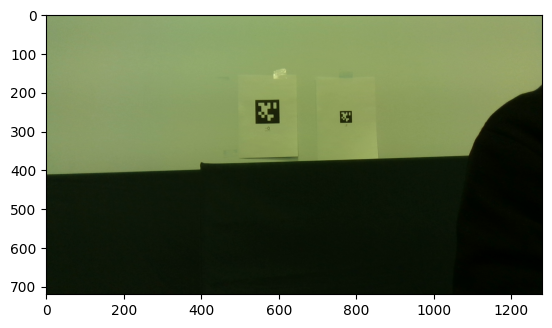

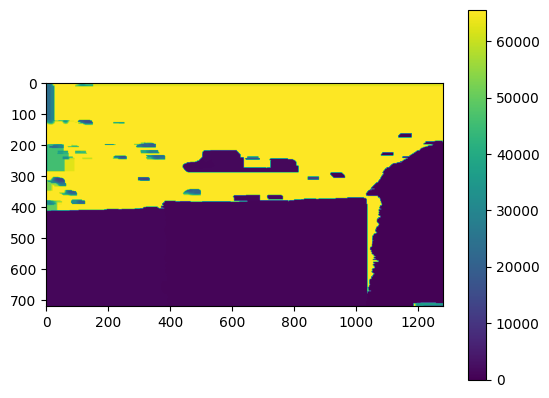

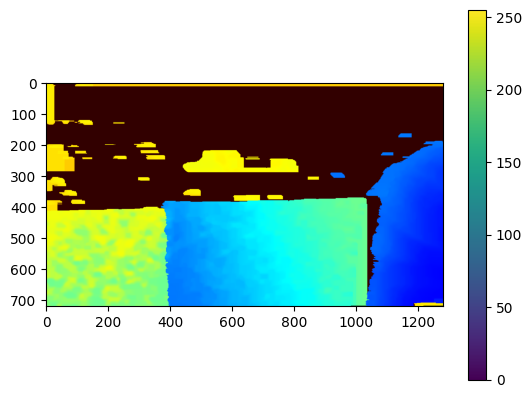

In [3]:
plt.imshow(color_img)
plt.show()

plt.imshow(depth_img)
plt.colorbar()
plt.show()

plt.imshow(depth_color_map)
plt.colorbar()
plt.show()



In [51]:

pipeline = rs.pipeline()

config = rs.config()
config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)
config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)

# Start streaming
pipeline.start(config)
align_to = rs.stream.color
align = rs.align(align_to)


# Wait for a coherent pair of frames: depth and color
frames = pipeline.wait_for_frames()
aligned_frames = align.process(frames)
depth_frame = aligned_frames.get_depth_frame()
color_frame = aligned_frames.get_color_frame()

# Apply filter to fill the Holes in the depth image
spatial = rs.spatial_filter()
spatial.set_option(rs.option.holes_fill, 3)
filtered_depth = spatial.process(depth_frame)

hole_filling = rs.hole_filling_filter()
filled_depth = hole_filling.process(filtered_depth)


# Create colormap to show the depth of the Objects
colorizer = rs.colorizer()
depth_colormap = np.asanyarray(colorizer.colorize(filled_depth).get_data())


# Convert images to numpy arrays
# distance = depth_frame.get_distance(int(50),int(50))
# print("distance", distance)
depth_image = np.asanyarray(filled_depth.get_data())
color_image = np.asanyarray(color_frame.get_data())

depth_colormap_dim = depth_colormap.shape
color_colormap_dim = color_image.shape

# If depth and color resolutions are different, resize color image to match depth image for display
if depth_colormap_dim != color_colormap_dim:
    resized_color_image = cv2.resize(color_image, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
    images = np.hstack((resized_color_image, depth_colormap))
else:
    images = np.hstack((color_image, depth_colormap))

# Show images
# cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
# cv2.imshow('RealSense', images)
# cv2.waitKey(1)

# cv2.destroyAllWindows()


RuntimeError: xioctl(VIDIOC_S_FMT) failed, errno=16 Last Error: Device or resource busy

Depth Scale is:  0.0010000000474974513


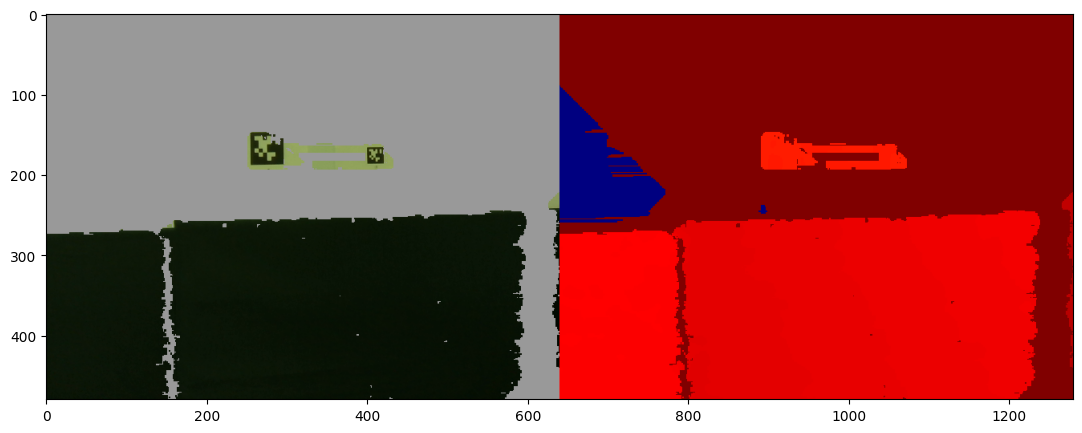

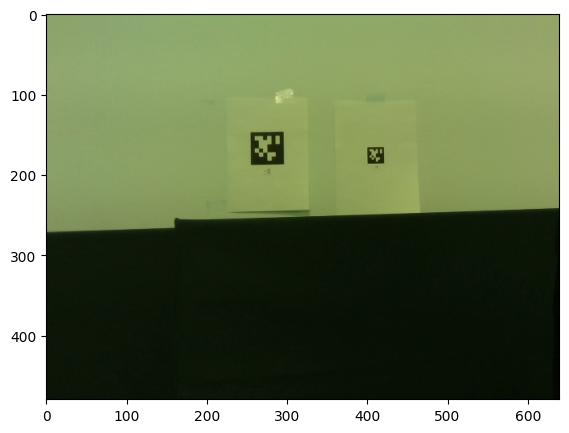

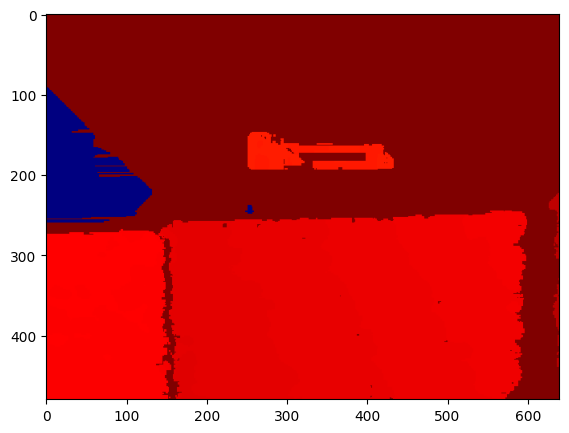

In [10]:
#align-depth2color.py
#
import pyrealsense2 as rs
import numpy as np
import cv2
import matplotlib.pyplot as plt

pipeline = rs.pipeline()    # realsense pipeline open
config = rs.config()        # config class 생성!
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)  # stream 종류, size, format 설정등록
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

profile = pipeline.start(config)   # pipeline start

depth_sensor = profile.get_device().first_depth_sensor()    # depth sensor에 대한 것들을 얻자
depth_scale = depth_sensor.get_depth_scale()                # 깊이 센서의 깊이 스케일 얻음
print("Depth Scale is: ", depth_scale)

clipping_distance_in_meters = 3    # 1 meter, 클리핑할 영역을 1m로 설정
clipping_distance = clipping_distance_in_meters / depth_scale   #스케일에 따른 클리핑 거리

align_to = rs.stream.color      #depth 이미지를 맞추기 위한 이미지, 컬러 이미지
align = rs.align(align_to)      #depth 이미지와 맞추기 위해 align 생성

frames = pipeline.wait_for_frames() #color와 depth의 프레임셋을 기다림
#frames.get_depth_frame() 은 640x360 depth 이미지이다.

aligned_frames= align.process(frames)   #모든(depth 포함) 프레임을 컬러 프레임에 맞추어 반환

aligned_depth_frame = aligned_frames.get_depth_frame()  #  aligned depth 프레임은 640x480 의 depth 이미지이다
color_frame = aligned_frames.get_color_frame()      #컬러 프레임을 얻음

depth_image = np.asanyarray(aligned_depth_frame.get_data())     #depth이미지를 배열로, 
color_image = np.asanyarray(color_frame.get_data())             #color 이미지를 배열로

#백그라운드 제거
grey_color = 153
depth_image_3d = np.dstack((depth_image, depth_image, depth_image))  #depth image는 1채널, 컬러 이미지는 3채널
bg_removed = np.where((depth_image_3d > clipping_distance) | (depth_image_3d <= 0), grey_color, color_image)
# 클리핑 거리를 깊이 _이미지가 넘어서거나, 0보다 적으면, 회색으로 아니면 컬러 이미지로 반환

#이미지 렌더링
depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
    # applyColorMap(src, 필터) 필터를 적용함 , COLORMAP_JET=  연속적인 색상, blue -> red
    # convertScaleAbs: 인자적용 후 절대값, 8비트 반환

images = np.hstack((bg_removed, depth_colormap))  #두 이미지를 수평으로 연결
plt.figure(figsize=(15,5))
plt.imshow(images)   #이미지 윈도우 정의
plt.show()
# cv2.imshow('Align Example', images)         #이미지를 넣어 윈도우에 보임

plt.figure(figsize=(15,5))
plt.imshow(color_image)   #이미지 윈도우 정의
plt.show()

plt.figure(figsize=(15,5))
plt.imshow(depth_colormap)   #이미지 윈도우 정의
plt.show()

pipeline.stop()     #리얼센스 데이터 스트리밍 중지